# SALES PREDICTION USING ARIMA AND PROPHET FOR BRAZILIAN E-COMMERCE

The dataset was generously provided by Olist, the largest department store in Brazilian marketplaces. Olist connects small businesses from all over Brazil to channels without hassle and with a single contract. Those merchants are able to sell their products through the Olist Store and ship them directly to the customers using Olist logistics partners. See more on our website: www.olist.com

After a customer purchases the product from Olist Store a seller gets notified to fulfill that order. Once the customer receives the product, or the estimated delivery date is due, the customer gets a satisfaction survey by email where he can give a note for the purchase experience and write down some comments.

**What is ARIMA model?**

A. ARIMA(Auto Regressive Integrated Moving Average) is a combination of 2 models AR(Auto Regressive) & MA(Moving Average). It has 3 hyperparameters - P(auto regressive lags),d(order of differentiation),Q(moving avg.) which respectively comes from the AR, I & MA components. The AR part is correlation between prev & current time periods. To smooth out the noise, the MA part is used. The I part binds together the AR & MA parts.

# 📤 IMPORT LIBRARIES

In [1]:
!pip install statsmodels
!pip install pmdarima

In [ ]:
import numpy as np
import pandas as pd
from pandas.plotting import autocorrelation_plot
from scipy import stats
import os
import itertools

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
%matplotlib inline
pd.set_option('display.max_columns', 100)

import seaborn as sns
import statsmodels.api as sm

from pylab import rcParams

from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA

# elimina os warnings das bibliotecas
import warnings
warnings.filterwarnings('ignore')


# 💾 CHECK OUT THE DATA

In [23]:
df_orders = pd.read_csv("Documents/StackLabs/olist_orders_dataset.csv")
df_customers = pd.read_csv("Documents/StackLabs/olist_customers_dataset.csv")
df_item = pd.read_csv("Documents/StackLabs/olist_order_items_dataset.csv")
df_reviews = pd.read_csv("Documents/StackLabs/olist_order_reviews_dataset.csv")
df_products = pd.read_csv("Documents/StackLabs/olist_products_dataset.csv")
df_geolocation = pd.read_csv("Documents/StackLabs/olist_geolocation_dataset.csv")
df_sellers = pd.read_csv("Documents/StackLabs/olist_sellers_dataset.csv")
df_order_pay = pd.read_csv("Documents/StackLabs/olist_order_payments_dataset.csv")
df_category = pd.read_csv("Documents/StackLabs/product_category_name_translation.csv")

**MERGE DF_ORDERS WITH DF_CUSTOMERS**

In [24]:
df_orders = df_orders.merge(df_customers, on='customer_id', how='outer')

**ALL IN ONE**

In [25]:
# merge all the tables in one dataframe
df_train = df_orders.merge(df_item, on='order_id', how='left')
df_train = df_train.merge(df_order_pay, on='order_id', how='outer', validate='m:m')
df_train = df_train.merge(df_reviews, on='order_id', how='outer')
df_train = df_train.merge(df_products, on='product_id', how='outer')
df_train = df_train.merge(df_sellers, on='seller_id', how='outer')

**CONVERT DATE COLUMNS TO TIMESTAMP**

In [26]:
df_train['order_purchase_time'] = pd.to_datetime(df_train['order_purchase_timestamp']).dt.time

In [27]:
# Extracting attributes for purchase date - Date
df_train['order_purchase_timestamp'] = pd.to_datetime(df_train['order_purchase_timestamp']).dt.date
df_train['order_delivered_customer_date'] = pd.to_datetime(df_train['order_delivered_customer_date']).dt.date
df_train['order_estimated_delivery_date'] = pd.to_datetime(df_train['order_estimated_delivery_date']).dt.date
df_train['order_approved_at'] = pd.to_datetime(df_train['order_approved_at']).dt.date
df_train['order_delivered_carrier_date'] = pd.to_datetime(df_train['order_delivered_carrier_date']).dt.date

In [28]:
# Extracting attributes for purchase date - Year and Month
df_train['order_purchase_year'] = pd.to_datetime(df_train['order_purchase_timestamp']).dt.year
df_train['order_purchase_month'] = pd.to_datetime(df_train['order_purchase_timestamp']).dt.month
df_train['order_purchase_month_name'] = df_train['order_purchase_timestamp'].apply(lambda x: x.strftime('%b'))

In [29]:
# Extracting attributes for purchase date - Day and Day of Week
df_train['order_purchase_day'] = pd.to_datetime(df_train['order_purchase_timestamp']).apply(lambda x: x.day)
df_train['order_purchase_dayofweek'] = pd.to_datetime(df_train['order_purchase_timestamp']).apply(lambda x: x.dayofweek)
df_train['order_purchase_dayofweek_name'] = pd.to_datetime(df_train['order_purchase_timestamp']).dt.day_name()

In [30]:
df_train['order_purchase_timestamp'] = pd.to_datetime(df_train['order_purchase_timestamp'])
df_train['order_purchase_time'] = pd.to_datetime(df_train['order_purchase_time'],format='%H:%M:%S').dt.time
df_train['order_delivered_customer_date'] = pd.to_datetime(df_train['order_delivered_customer_date'])
df_train['order_estimated_delivery_date'] = pd.to_datetime(df_train['order_estimated_delivery_date'])


In [31]:
df_train.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix,seller_city,seller_state,order_purchase_time,order_purchase_year,order_purchase_month,order_purchase_month_name,order_purchase_day,order_purchase_dayofweek,order_purchase_dayofweek_name
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02,2017-10-02,2017-10-04,2017-10-10,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,1.0,credit_card,1.0,18.12,a54f0611adc9ed256b57ede6b6eb5114,4.0,NaN,"Não testei o produto ainda, mas ele veio corre...",2017-10-11 00:00:00,2017-10-12 03:43:48,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,9350.0,maua,SP,10:56:00,2017,10,Oct,2,0,Monday
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02,2017-10-02,2017-10-04,2017-10-10,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,3.0,voucher,1.0,2.00,a54f0611adc9ed256b57ede6b6eb5114,4.0,NaN,"Não testei o produto ainda, mas ele veio corre...",2017-10-11 00:00:00,2017-10-12 03:43:48,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,9350.0,maua,SP,10:56:00,2017,10,Oct,2,0,Monday
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02,2017-10-02,2017-10-04,2017-10-10,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,2.0,voucher,1.0,18.59,a54f0611adc9ed256b57ede6b6eb5114,4.0,NaN,"Não testei o produto ainda, mas ele veio corre...",2017-10-11 00:00:00,2017-10-12 03:43:48,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,9350.0,maua,SP,10:56:00,2017,10,Oct,2,0,Monday
3,128e10d95713541c87cd1a2e48201934,a20e8105f23924cd00833fd87daa0831,delivered,2017-08-15,2017-08-15,2017-08-17,2017-08-18,2017-08-28,3a51803cc0d012c3b5dc8b7528cb05f7,3366,sao paulo,SP,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-08-21 20:05:16,29.99,7.78,1.0,credit_card,3.0,37.77,b46f1e34512b0f4c74a72398b03ca788,4.0,NaN,Deveriam embalar melhor o produto. A caixa vei...,2017-08-19 00:00:00,2017-08-20 15:16:36,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,9350.0,maua,SP,18:29:00,2017,8,Aug,15,1,Tuesday
4,0e7e841ddf8f8f2de2bad69267ecfbcf,26c7ac168e1433912a51b924fbd34d34,delivered,2017-08-02,2017-08-02,2017-08-04,2017-08-07,2017-08-15,ef0996a1a279c26e7ecbd737be23d235,2290,sao paulo,SP,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-08-08 18:37:31,29.99,7.78,1.0,credit_card,1.0,37.77,dc90f19c2806f1abba9e72ad3c350073,5.0,NaN,"Só achei ela pequena pra seis xícaras ,mais é ...",2017-08-08 00:00:00,2017-08-08 23:26:23,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,9350.0,maua,SP,18:24:00,2017,8,Aug,2,2,Wednesday


In [32]:
df_train_state=df_train

In [33]:
df_orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99441 entries, 0 to 99440
Data columns (total 12 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
 8   customer_unique_id             99441 non-null  object
 9   customer_zip_code_prefix       99441 non-null  int64 
 10  customer_city                  99441 non-null  object
 11  customer_state                 99441 non-null  object
dtypes: int64(1), object(11)
memory usage: 9.9+ MB


**CLEAN DATA**

<iframe src="https://www.kaggle.com/embed/fekmea/preparation-olist-dataset/notebook?cellIds=10&kernelSessionId=80861728" height="300" style="margin: 0 auto; width: 100%; max-width: 950px;" frameborder="0" scrolling="auto" title="Preparation Olist dataset"></iframe>

In [36]:
df_orders.isnull().sum().sort_values(ascending = False).head()

order_delivered_customer_date    2965
order_delivered_carrier_date     1783
order_approved_at                 160
order_id                            0
customer_id                         0
dtype: int64

In [37]:
df_train.isnull().sum().sort_values(ascending = False).head()

review_comment_title             105154
review_comment_message            68898
order_delivered_customer_date      3421
product_photos_qty                 2542
product_description_lenght         2542
dtype: int64

In [38]:
# We may drop the review_comment_title column, as all values are null
df_train.drop(['review_comment_title'], axis=1, inplace=True)

Default review comment message

In [39]:
df_train['review_comment_message'] = df_train['review_comment_message'].fillna('No message')

Drop nan values

In [40]:
df_train_0 = df_train.shape[0]
#Remove missing values with dropna
df_train= df_train.dropna()
df_train_1 = df_train.shape[0]
print(f'{round(((df_train_0-df_train_1)/df_train_1)*100,2)}% nan values points were eliminated')

5.24% nan values points were eliminated


In [41]:
df_orders_0 = df_orders.shape[0]
#Remove missing values with dropna
df_orders= df_orders.dropna()
df_orders_1 = df_orders.shape[0]
print(f'{round(((df_orders_0-df_orders_1)/df_orders_1)*100,2)}% nan values points were eliminated')

3.09% nan values points were eliminated


Is that a growing trend on e-commerce in Brazil? How can we describe a complete scenario?

In [90]:
# Changing the data type for date columns
timestamp_cols = ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 
                  'order_estimated_delivery_date']
for col in timestamp_cols:
    df_orders[col] = pd.to_datetime(df_orders[col])
    
# Extracting attributes for purchase date - Year and Month
df_orders['order_purchase_year'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.year)
df_orders['order_purchase_month'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.month)
df_orders['order_purchase_month_name'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.strftime('%b'))
df_orders['order_purchase_year_month'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.strftime('%Y-%m'))
df_orders['order_purchase_date'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.strftime('%Y%m%d'))

#To create a Week column, in the format yyyy-ww, use:
df_orders['order_purchase_year_week'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.strftime('%Y-%U'))


# Extracting attributes for purchase date - Day and Day of Week
df_orders['order_purchase_day'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.day)
df_orders['order_purchase_dayofweek'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.dayofweek)
df_orders['order_purchase_weekofyear'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.weekofyear)
df_orders['order_purchase_dayofweek_name'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.strftime('%a'))

# Extracting attributes for purchase date - Hour and Time of the Day
df_orders['order_purchase_hour'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.hour)
hours_bins = [-0.1, 6, 12, 18, 23]
hours_labels = ['Dawn', 'Morning', 'Afternoon', 'Night']
df_orders['order_purchase_time_day'] = pd.cut(df_orders['order_purchase_hour'], hours_bins, labels=hours_labels)

# New DataFrame after transformations
df_orders

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_purchase_year,order_purchase_month,order_purchase_month_name,order_purchase_year_month,order_purchase_date,order_purchase_day,order_purchase_dayofweek,order_purchase_weekofyear,order_purchase_dayofweek_name,order_purchase_hour,order_purchase_time_day,order_purchase_year_week
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:00,2017-10-02 11:07:00,2017-10-04 19:55:00,10/10/2017 21:25,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,2017,10,Oct,2017-10,20171002,2,0,40,Mon,10,Morning,2017-40
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:00,2018-07-26 03:24:00,2018-07-26 14:31:00,8/7/2018 15:27,2018-08-13,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,2018,7,Jul,2018-07,20180724,24,1,30,Tue,20,Night,2018-29
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:00,2018-08-08 08:55:00,2018-08-08 13:50:00,8/17/2018 18:06,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,2018,8,Aug,2018-08,20180808,8,2,32,Wed,8,Morning,2018-31
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:00,2017-11-18 19:45:00,2017-11-22 13:39:00,12/2/2017 0:28,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,2017,11,Nov,2017-11,20171118,18,5,46,Sat,19,Night,2017-46
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:00,2018-02-13 22:20:00,2018-02-14 19:46:00,2/16/2018 18:17,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP,2018,2,Feb,2018-02,20180213,13,1,7,Tue,21,Night,2018-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99436,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09 09:54:00,2017-03-09 09:54:00,2017-03-10 11:18:00,3/17/2017 15:08,2017-03-28,6359f309b166b0196dbf7ad2ac62bb5a,12209,sao jose dos campos,SP,2017,3,Mar,2017-03,20170309,9,3,10,Thu,9,Morning,2017-10
99437,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:00,2018-02-06 13:10:00,2018-02-07 23:22:00,2/28/2018 17:37,2018-03-02,da62f9e57a76d978d02ab5362c509660,11722,praia grande,SP,2018,2,Feb,2018-02,20180206,6,1,6,Tue,12,Morning,2018-05
99438,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:00,2017-08-27 15:04:00,2017-08-28 20:52:00,9/21/2017 11:24,2017-09-27,737520a9aad80b3fbbdad19b66b37b30,45920,nova vicosa,BA,2017,8,Aug,2017-08,20170827,27,6,34,Sun,14,Afternoon,2017-35
99439,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:00,2018-01-08 21:36:00,2018-01-12 15:35:00,1/25/2018 23:32,2018-02-15,5097a5312c8b157bb7be58ae360ef43c,28685,japuiba,RJ,2018,1,Jan,2018-01,20180108,8,0,2,Mon,21,Night,2018-01


# VISUALIZATION

# Price Distribution

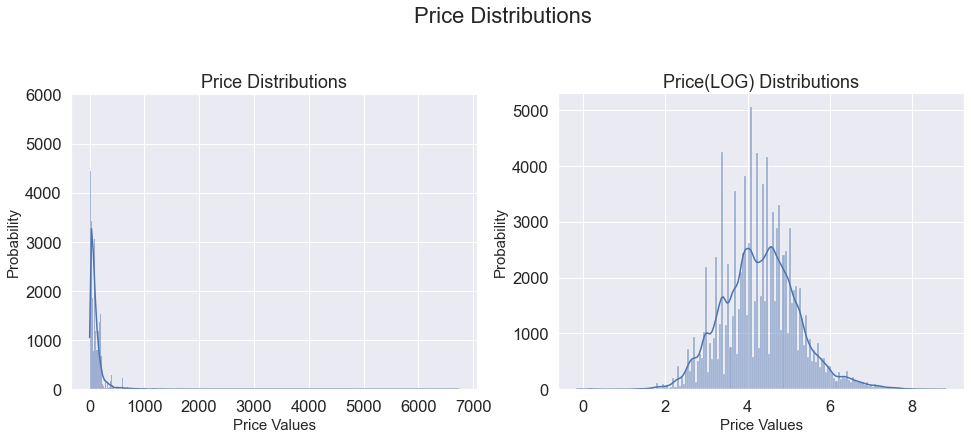

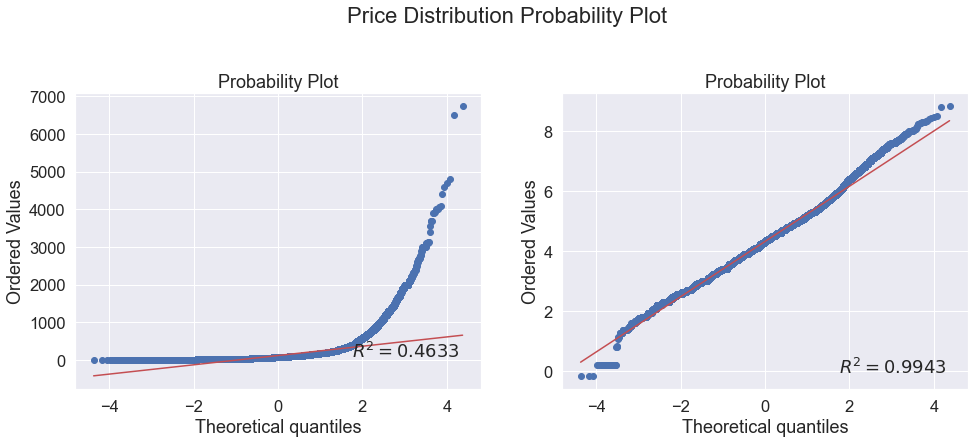

In [49]:
# Getting the histogram and normal probability plot
plt.figure(figsize=(16,12))
plt.suptitle('Price Distributions', fontsize=22)
plt.subplot(221)
g = sns.histplot(df_train['price'], kde=True)
g.set_title("Price Distributions", fontsize=18)
g.set_xlabel("Price Values", fontsize=15)
g.set_ylabel("Probability", fontsize=15)

plt.subplot(222)
g1 = sns.histplot(np.log(df_train['price']), kde=True)
g1.set_title("Price(LOG) Distributions", fontsize=18)
g1.set_xlabel("Price Values", fontsize=15)
g1.set_ylabel("Probability", fontsize=15)

plt.show()

plt.figure(figsize=(16,12))

plt.suptitle('Price Distribution Probability Plot', fontsize=22)

plt.subplot(221)
res = stats.probplot(df_train['price'], plot=plt, fit=True, rvalue=True);


plt.subplot(222)
res = stats.probplot(np.log(df_train['price']), plot=plt, fit=True, rvalue=True);

plt.show()

**Price Distribution:**
Histogram of a sample from a right-skewed distribution – it looks unimodal and skewed right.

**Price Log Distribution:**
Histogram of a sample from a normal distribution – it looks fairly symmetric and unimodal.

**Probability Plot - Price Distribution:**
Normal probability plot of a sample from a right-skewed distribution – it has an inverted C shape.

**Probability Plot - Price Log Distribution:**
Normal probability plot of a sample from a normal distribution – it looks fairly straight, at least when the few large and small values are ignored.

# **Order purchase year-week Distribution**

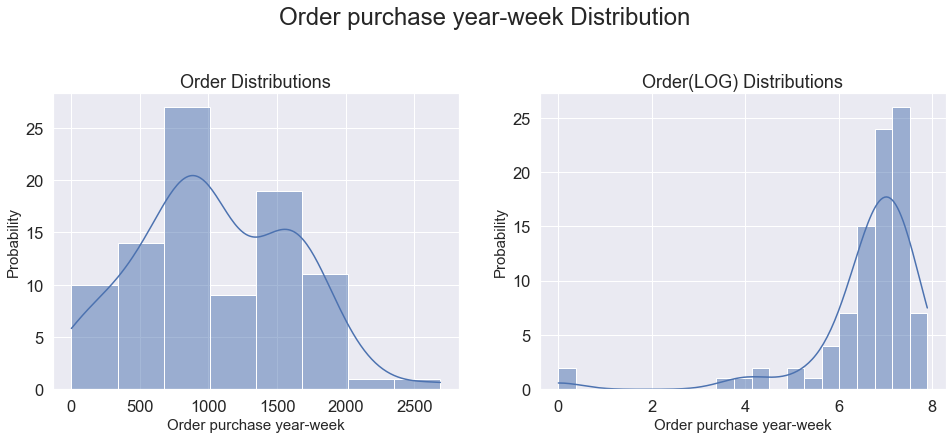

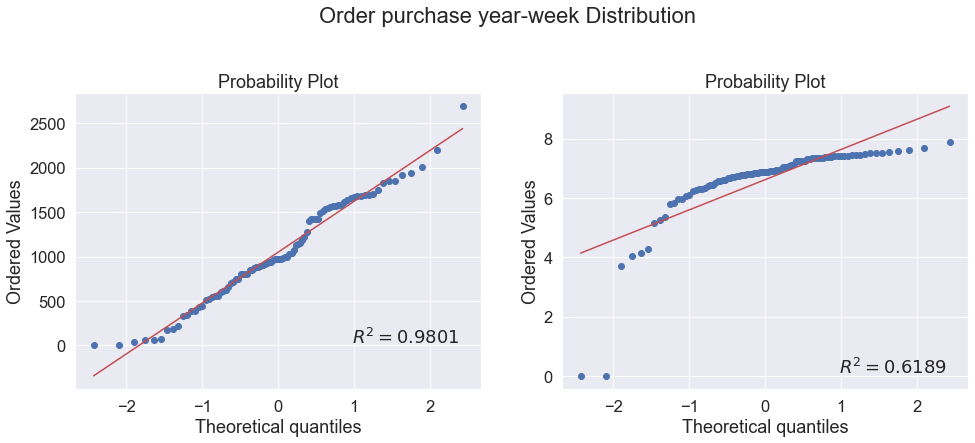

In [99]:
# Getting the histogram and normal probability plot
plt.figure(figsize=(16,12))
plt.suptitle('Order purchase year-week Distribution', fontsize=24)
plt.subplot(221)
g = sns.histplot(df_orders['order_purchase_year_week'].value_counts(), kde=True)
g.set_title("Order Distributions", fontsize=18)
g.set_xlabel("Order purchase year-week", fontsize=15)
g.set_ylabel("Probability", fontsize=15)

plt.subplot(222)
g1 = sns.histplot(np.log(df_orders['order_purchase_year_week'].value_counts()), kde=True)
g1.set_title("Order(LOG) Distributions", fontsize=18)
g1.set_xlabel("Order purchase year-week", fontsize=15)
g1.set_ylabel("Probability", fontsize=15)

plt.show()

plt.figure(figsize=(16,12))

plt.suptitle('Order purchase year-week Distribution', fontsize=22)

plt.subplot(221)
res = stats.probplot(df_orders['order_purchase_year_week'].value_counts(), plot=plt, fit=True, rvalue=True);


plt.subplot(222)
res = stats.probplot(np.log(df_orders['order_purchase_year_week'].value_counts()), plot=plt, fit=True, rvalue=True);

plt.show()

Let's Check the Features Through the Time

Our current timestamps can be tricky to work with, so we'll be using the average daily price amount for that month, and we're using the start of each month as the timestamp.

In [50]:
df_train['order_purchase_timestamp'].min(), df_train['order_purchase_timestamp'].max()

(Timestamp('2016-10-03 00:00:00'), Timestamp('2018-08-29 00:00:00'))

In [101]:
df_orders['order_purchase_year_month'].min(), df_orders['order_purchase_year_month'].max()

('2016-09', '2018-08')

In [55]:
df_orders['order_purchase_weekofyear'].min(), df_orders['order_purchase_weekofyear'].max()

(1, 52)

In [102]:
df_orders['order_purchase_year_week'].min(), df_orders['order_purchase_year_week'].max()

('2016-37', '2018-34')

In [103]:
df_train = df_train.groupby('order_purchase_timestamp')['price'].sum().reset_index()
df_train

,order_purchase_timestamp,price
0,2016-10-03,463.48
1,2016-10-04,9093.20
2,2016-10-05,6329.57
3,2016-10-06,5889.96
4,2016-10-07,6205.25
...,...,...
606,2018-08-25,10711.93
607,2018-08-26,8235.71
608,2018-08-27,5343.67
609,2018-08-28,3757.51


**Creating dataframes to predict in 3 different time intervals**

In [108]:
#number of orders per month of the year
df_orders_year_month=df_orders['order_purchase_year_month'].value_counts().sort_index()
#number of orders per week of the year (the year has 52 weeks)
df_orders_weekofyear=df_orders['order_purchase_weekofyear'].value_counts().sort_index()
#number of orders per year-week
df_orders_year_week=df_orders['order_purchase_year_week'].value_counts().sort_index()

# **Order Time Series Data**

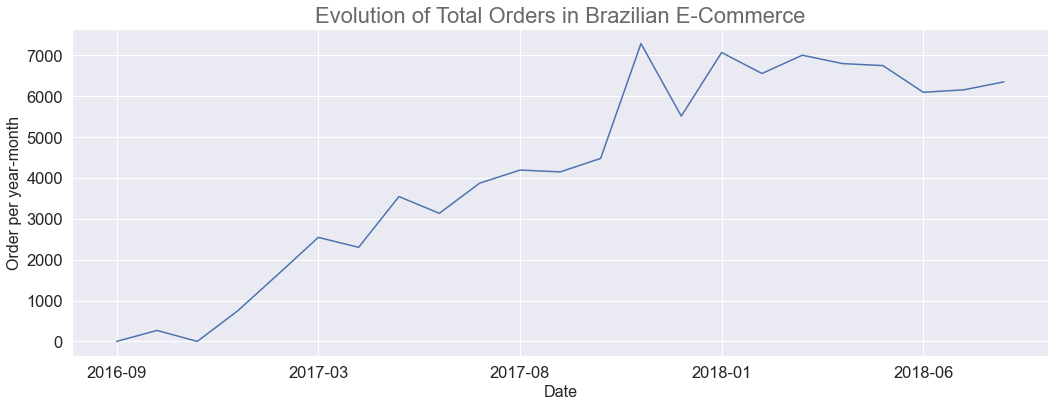

In [117]:
fig = plt.figure(constrained_layout=True, figsize=(13, 10))
df_orders_year_month.plot(figsize=(15, 6))
plt.xlabel('Date', size=16)
plt.ylabel('Order per year-month', size=16)
plt.title('Evolution of Total Orders in Brazilian E-Commerce', size=22, color='dimgrey')
plt.tight_layout()
plt.show()

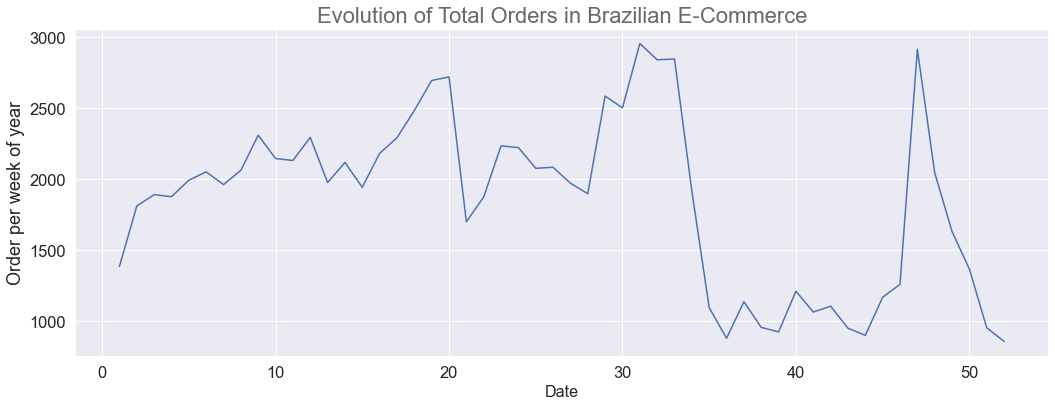

In [120]:
fig = plt.figure(constrained_layout=True, figsize=(13, 10))
df_orders_weekofyear.plot(figsize=(15, 6))
plt.xlabel('Date', size=16)
plt.ylabel('Order per week of year')
plt.title('Evolution of Total Orders in Brazilian E-Commerce', size=22, color='dimgrey')
plt.tight_layout()
plt.show()

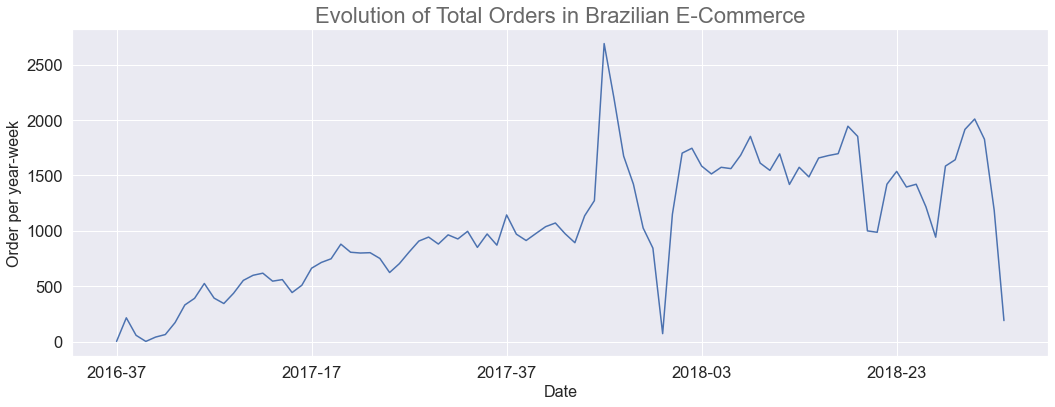

In [129]:

df_orders_year_week.plot(figsize=(15, 6))
plt.xlabel('Date', size=16)
plt.ylabel('Order per year-week', size=16)
plt.title('Evolution of Total Orders in Brazilian E-Commerce', size=22, color='dimgrey')
plt.tight_layout()
plt.show()

In [127]:
#Determine rolling statistics for times series with year-month
df_orders_year_month_mean = df_orders_year_month.rolling(window=12).mean() #window size 12 denotes 12 months, giving rolling mean at yearly level
df_orders_year_month_std = df_orders_year_month.rolling(window=12).std()
print(df_orders_year_month_mean,df_orders_year_month_std)

2016-09            NaN
2016-10            NaN
2016-12            NaN
2017-01            NaN
2017-02            NaN
2017-03            NaN
2017-04            NaN
2017-05            NaN
2017-06            NaN
2017-07            NaN
2017-08            NaN
2017-09    2200.333333
2017-10    2573.416667
2017-11    3158.250000
2017-12    3617.583333
2018-01    4144.333333
2018-02    4553.916667
2018-03    4925.333333
2018-04    5299.916667
2018-05    5566.916667
2018-06    5813.666667
2018-07    6004.000000
2018-08    6183.833333
Name: order_purchase_year_month, dtype: float64 2016-09            NaN
2016-10            NaN
2016-12            NaN
2017-01            NaN
2017-02            NaN
2017-03            NaN
2017-04            NaN
2017-05            NaN
2017-06            NaN
2017-07            NaN
2017-08            NaN
2017-09    1629.185370
2017-10    1591.942750
2017-11    1923.403854
2017-12    1751.339252
2018-01    1760.352823
2018-02    1695.545472
2018-03    1703.859114
2018-04  

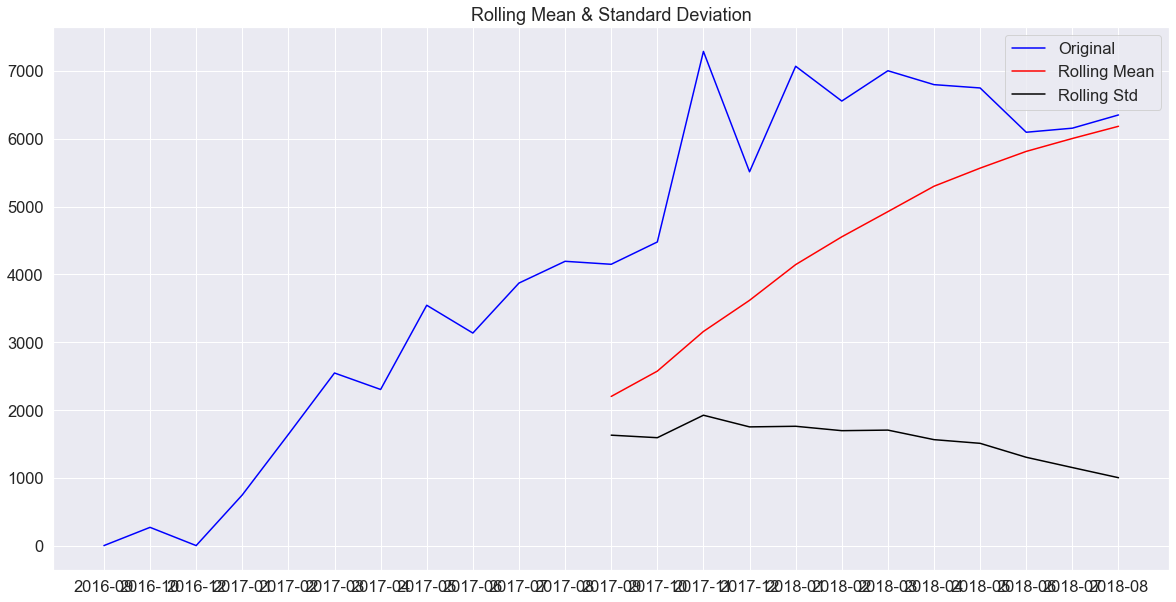

In [128]:
#Plot rolling statistics
plt.figure(figsize=(20,10))
orig = plt.plot(df_orders_year_month, color='blue', label='Original')
df_orders_year_month_mean = plt.plot(df_orders_year_month_mean, color='red', label='Rolling Mean')
df_orders_year_month_std = plt.plot(df_orders_year_month_std, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

# Series decomposition ???? HELP

In [131]:

# Primeiro, vamos decompor a série pra avaliar tendência
# Sazonalidade e resíduo
from statsmodels.tsa.seasonal import seasonal_decompose

resultado = seasonal_decompose(df_orders_year_week)

fig = plt.figure(figsize=(8, 6))  
fig = resultado.plot()

ValueError: You must specify a period or x must be a pandas object with a DatetimeIndex with a freq not set to None

**TESTE DE ESTACIONARIEDADE**

In [132]:
# Teste de estacionariedade. 
# A hipótese nula é que a série não é estacionária
# Ou seja, se o p-valor for menor que 0,05, rejeitamos
# que a série não é estacionária. Caso seja maior, não podemos
# descartar que a série não é estacionária
from statsmodels.tsa.stattools import adfuller

result=adfuller(df_orders_year_month.dropna())
print(f'Teste ADF:{result[0]}')
print(f'p-valor:{result[1]}')

Teste ADF:-1.7895872416413952
p-valor:0.38564345586227744


**Como p-valor >0.05, não rejeita-se a hipótese nula de que a série não é estacionária.**

# ARIMA Model for Time Series Forecasting

Let's apply one of the most used methods for forecasting time series, known as ARIMA, which stands Autoregressive Integrated Moving Average.

ARIMA models are denoted with the ARIMA notation (p, d, q). These three parameters are responsible for the seasonality, trend and noise in the data:

In [133]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [134]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(df_orders_year_month,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            #enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue           


ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:457.617781586953
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:455.82004761251727
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:218.77980424170207
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:217.75941176419187
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:455.8058726163184
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:457.5712799013505
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:162.1266919569136
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:218.1446604418742
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:438.43966366612875
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:436.4262245745831
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:209.5186217259707
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:209.04642764108507
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:450.5661813465984
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:438.30319752392
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:208.4694279514722
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:210.46942795244783
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:365.4809467100859
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:366.6160847092865
ARIMA(0

A saída acima sugere que o SARIMAX (0,1,0) x (0, 1, 0, 12) produz o menor valor de AIC de 4.0. Portanto, devemos considerar sso como  melhor opção.


# Adjusting the ARIMA model

                                   SARIMAX Results                                   
Dep. Variable:     order_purchase_year_month   No. Observations:                   23
Model:                        ARIMA(0, 1, 0)   Log Likelihood                -181.740
Date:                       Fri, 07 Jan 2022   AIC                            365.481
Time:                               01:12:09   BIC                            366.572
Sample:                                    0   HQIC                           365.738
                                        - 23                                         
Covariance Type:                         opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      8.752e+05   1.89e+05      4.637      0.000    5.05e+05    1.25e+06
Ljung-Box (L1) (Q):                   7.66   Jarque-Bera (JB):             

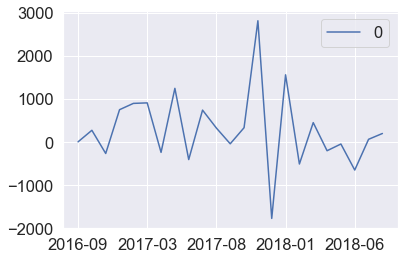

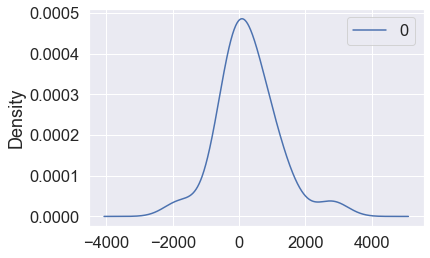

                 0
count    23.000000
mean    276.130435
std     892.771492
min   -1775.000000
25%    -224.000000
50%     195.000000
75%     742.000000
max    2810.000000


In [137]:
from statsmodels.tsa.arima.model import ARIMA
from pandas import DataFrame
# fit model
model = ARIMA(df_orders_year_month, order=(0,1,0))
model_fit = model.fit()
# summary of fit model
print(model_fit.summary())
# line plot of residuals
residuals = DataFrame(model_fit.resid)
residuals.plot()
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals.describe())

In [141]:
# Agora que sabemos os melhores parâmetros, vamos criar um modelo SARIMAX (versão do arima com parametros para sazonalidade)

mod = sm.tsa.statespace.SARIMAX(df_orders_year_month,
                                order=(0, 1, 0),
                                seasonal_order=(0, 1, 0, 12),
                                enforce_invertibility=False)
results = mod.fit(disp=False)
print(results.summary().tables[1])
results.summary()

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.348e+06   6.12e+05      2.202      0.028    1.48e+05    2.55e+06


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:          order_purchase_year_month   No. Observations:                   23
Model:             SARIMAX(0, 1, 0)x(0, 1, 0, 12)   Log Likelihood                 -84.867
Date:                            Fri, 07 Jan 2022   AIC                            171.733
Time:                                    01:19:23   BIC                            172.036
Sample:                                         0   HQIC                           171.401
                                             - 23                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.348e+06   6.12e+05      2.202      0.028    1.48e+05    2.55e+06
===================================================================================
Ljung-Box (L1) (Q):                   2.92   Jarque-Bera (JB):                 2.46
Prob(Q):                              0.09   Prob(JB):                         0.29
Heteroskedasticity (H):               0.06   Skew:                             1.15
Prob(H) (two-sided):                  0.04   Kurtosis:                         3.78
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [190]:
# Vamos realizar um "backtesting" com predições de valores dos 12 meses anteriores
predicoes = results.get_prediction(start=1)
predicao_media = predicoes.predicted_mean

In [191]:
# intervalo de confiança

intervalo_confianca = predicoes.conf_int()
limites_abaixo = intervalo_confianca.iloc[:,0]
limites_acima = intervalo_confianca.iloc[:,1]

limites_abaixo[0], limites_acima[0]

(-3002.3283538744986, 3004.3283538744986)

In [192]:
predicao_media[0]

0.9999999999999999

In [193]:
datas_previsao = np.asarray(predicao_media.index)
datas = np.asarray(df_orders_year_month.index)

[]

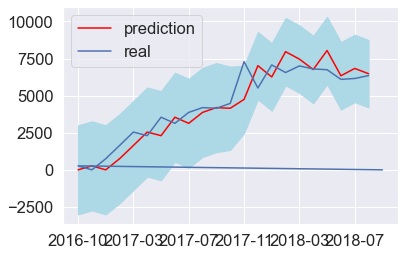

In [194]:
fig, ax = plt.subplots(1,1)
plt.plot(datas_previsao,predicao_media.values,color='red',label='prediction')
plt.fill_between(datas_previsao, limites_abaixo, limites_acima, color='lightblue')
plt.plot(df_orders_year_month, label='real')
ax.set_xticks(ax.get_xticks()[::4])
plt.legend()
plt.plot()

In [196]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rmse_sarima = sqrt(mean_squared_error(df_orders_year_month[1:].values,predicao_media.values))
print(rmse_sarima)

919.7831024829518


**Customer's State Distribution**

In [122]:
df_train_state

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value,review_id,review_score,review_comment_message,review_creation_date,review_answer_timestamp,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix,seller_city,seller_state,order_purchase_time,order_purchase_year,order_purchase_month,order_purchase_month_name,order_purchase_day,order_purchase_dayofweek,order_purchase_dayofweek_name
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02,2017-10-02,2017-10-04,2017-10-10,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,1.0,credit_card,1.0,18.12,a54f0611adc9ed256b57ede6b6eb5114,4.0,"Não testei o produto ainda, mas ele veio corre...",2017-10-11 00:00:00,2017-10-12 03:43:48,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,9350.0,maua,SP,10:56:00,2017,10,Oct,2,0,Monday
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02,2017-10-02,2017-10-04,2017-10-10,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,3.0,voucher,1.0,2.00,a54f0611adc9ed256b57ede6b6eb5114,4.0,"Não testei o produto ainda, mas ele veio corre...",2017-10-11 00:00:00,2017-10-12 03:43:48,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,9350.0,maua,SP,10:56:00,2017,10,Oct,2,0,Monday
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02,2017-10-02,2017-10-04,2017-10-10,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,2.0,voucher,1.0,18.59,a54f0611adc9ed256b57ede6b6eb5114,4.0,"Não testei o produto ainda, mas ele veio corre...",2017-10-11 00:00:00,2017-10-12 03:43:48,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,9350.0,maua,SP,10:56:00,2017,10,Oct,2,0,Monday
3,128e10d95713541c87cd1a2e48201934,a20e8105f23924cd00833fd87daa0831,delivered,2017-08-15,2017-08-15,2017-08-17,2017-08-18,2017-08-28,3a51803cc0d012c3b5dc8b7528cb05f7,3366,sao paulo,SP,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-08-21 20:05:16,29.99,7.78,1.0,credit_card,3.0,37.77,b46f1e34512b0f4c74a72398b03ca788,4.0,Deveriam embalar melhor o produto. A caixa vei...,2017-08-19 00:00:00,2017-08-20 15:16:36,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,9350.0,maua,SP,18:29:00,2017,8,Aug,15,1,Tuesday
4,0e7e841ddf8f8f2de2bad69267ecfbcf,26c7ac168e1433912a51b924fbd34d34,delivered,2017-08-02,2017-08-02,2017-08-04,2017-08-07,2017-08-15,ef0996a1a279c26e7ecbd737be23d235,2290,sao paulo,SP,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-08-08 18:37:31,29.99,7.78,1.0,credit_card,1.0,37.77,dc90f19c2806f1abba9e72ad3c350073,5.0,"Só achei ela pequena pra seis xícaras ,mais é ...",2017-08-08 00:00:00,2017-08-08 23:26:23,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,9350.0,maua,SP,18:24:00,2017,8,Aug,2,2,Wednesday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119138,1ab38815794efa43d269d62b98dae815,a0b67404d84a70ef420a7f99ad6b190a,delivered,2018-07-01,2018-07-05,2018-07-04,2018-07-09,2018-07-20,2077f7ec37df79c62cc24b7b8f30e8c9,8528,ferraz de vasconcelos,SP,1.0,31ec3a565e06de4bdf9d2a511b822b4d,babcc0ab201e4c60188427cae5

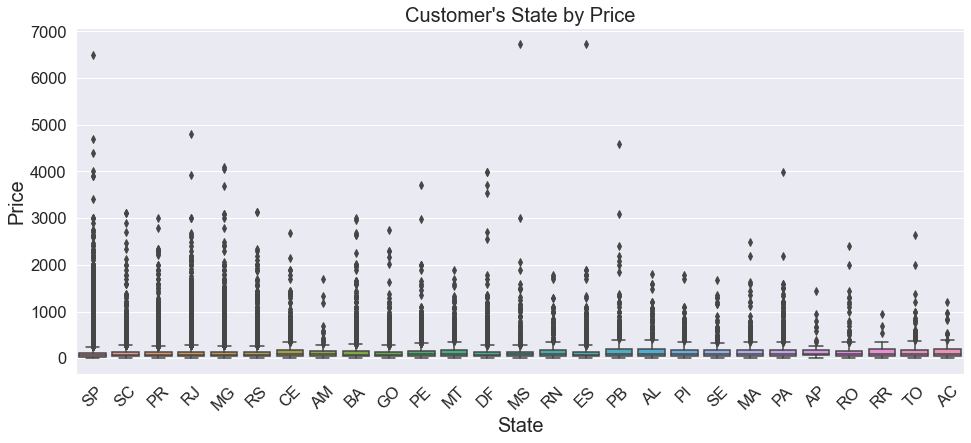

In [123]:
plt.figure(figsize=(35,14))

plt.subplot(221)
sns.set(font_scale=1.5) 
g2 = sns.boxplot(x='customer_state', y='price', 
                 data=df_train_state[df_train_state['price'] != -1])
g2.set_title("Customer's State by Price", fontsize=20)
g2.set_xlabel("State", fontsize=20)
g2.set_ylabel("Price", fontsize=20)
g2.set_xticklabels(g2.get_xticklabels(),rotation=45)

plt.show()

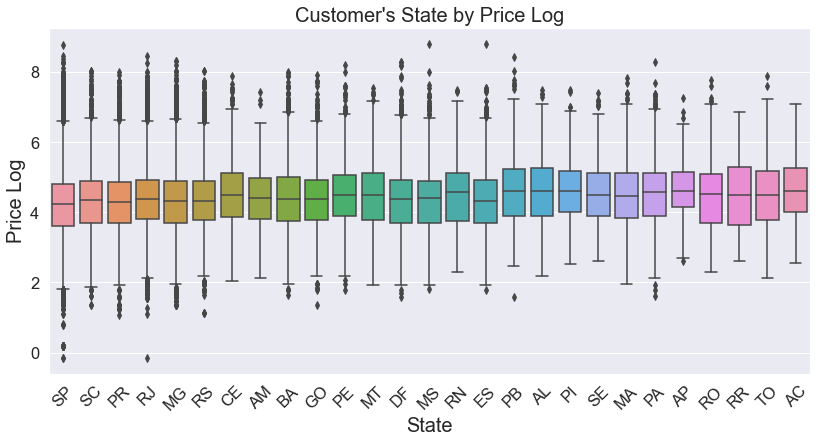

In [124]:
plt.figure(figsize=(30,14))
df_train_state['price_log'] = np.log(df_train_state['price'])

plt.subplot(221)
sns.set(font_scale=1.5) 
g2 = sns.boxplot(x='customer_state', y='price_log', 
                 data=df_train_state[df_train_state['price'] != -1])
g2.set_title("Customer's State by Price Log", fontsize=20)
g2.set_xlabel("State", fontsize=20)
g2.set_ylabel("Price Log", fontsize=20)
g2.set_xticklabels(g2.get_xticklabels(),rotation=45)

plt.show()

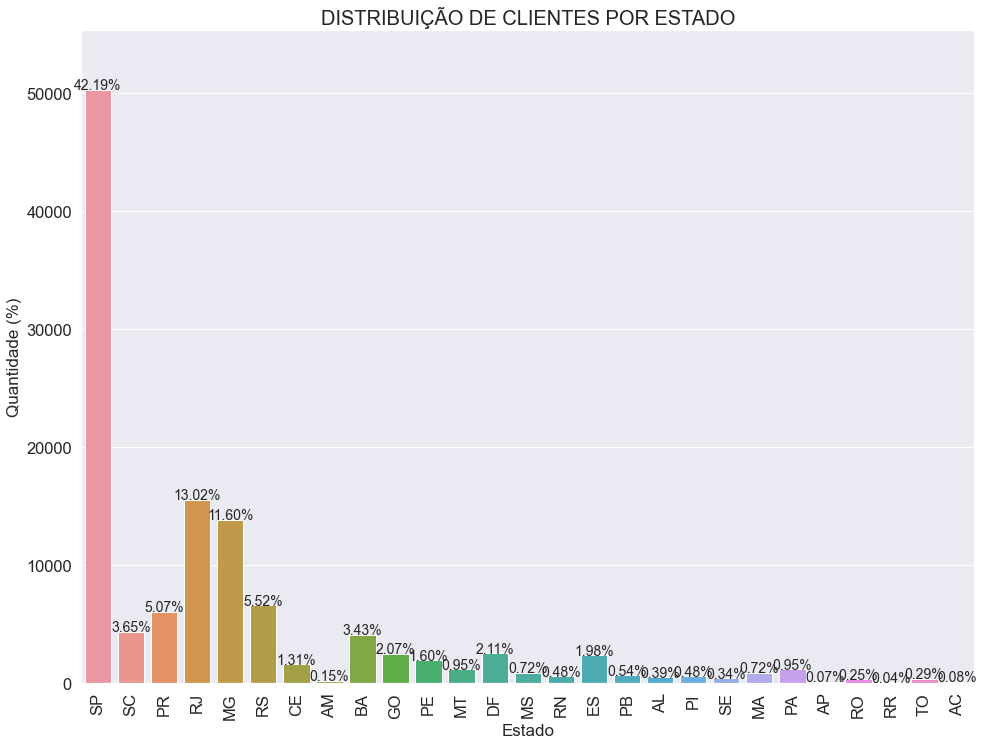

In [125]:
plt.figure(figsize=(16,12))

g = sns.countplot(x='customer_state', data=df_train_state, orient='h', order = merge_df['customer_state'].value_counts().index)
g.set_title("DISTRIBUIÇÃO DE CLIENTES POR ESTADO", fontsize=20)
g.set_xlabel("Estado", fontsize=17)
g.set_ylabel("Quantidade (%)", fontsize=17)
g.set_xticklabels(g.get_xticklabels(),rotation=90)
sizes = []
total=len(df_train_state)

for p in g.patches:
    height = p.get_height()
    sizes.append(height)
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=14) 
g.set_ylim(0, max(sizes) * 1.1)

plt.show()


**References:**

https://github.com/letsdata/series-temporais-python/blob/main/series-temporais-python.ipynb


https://www.kaggle.com/thiagopanini/e-commerce-sentiment-analysis-eda-viz-nlp